# Week 9 - Dimensionality reduction

In this lab, you'll get a chance to experiment with library implementations of the dimensionality reduction techniques discussed in lecture.

You will not be implementing the algorithms yourself. Instead you will be expected to use the library methods by reading the online documentation. This is intended to be practical experience - finding solutions based on existing libraries is usually much more practical than implementing a solution from scratch!

### Installation notes

To run this notebook you will need to install several packages:

    conda install pandas
    conda install scikit-learn
    conda install -c conda-forge umap-learn
    conda install -c conda-forge altair vega

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import gzip
import re
from urllib.request import urlretrieve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from umap import UMAP

In [4]:
import altair

In [5]:
import matplotlib.pyplot as plt
# Set default figure size to a larger size
plt.rcParams['figure.figsize'] = [10, 10]

If it is not already present in your repository, the following code will download the raw [FlyAtlas](http://flyatlas.org/atlas.cgi) data from [NCBI's Gene Expression Omnibus](https://www.ncbi.nlm.nih.gov/geo/). It may take a few moments to download.

In [6]:
#urlretrieve("ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE7nnn/GSE7763/matrix/GSE7763_series_matrix.txt.gz", 
#            filename="data/flydata.txt.gz")

The following two cells will open the compressed file you downloaded from GEO into a `pandas` data frame, then reopen the file and parse out the sample title line in order to use this as the column names for the data frame.

In [7]:
with gzip.open("./flydata.txt.gz") as handle:
    expression = pd.read_csv(handle, sep="\t", comment="!", index_col=0)

In [8]:
with gzip.open("./flydata.txt.gz") as handle:
    for line in handle:
        line = line.decode("utf-8")
        if line.startswith("!Sample_title"):
            header = [x.strip('"') for x in line.split("\t")[1:]]
            expression.columns = header
            break

Output the data frame and see what we have. It should have microarray probe ID's as row names (these can be mapped to gene names but we will skip that for today) and sample names as column names.

The data frame has 18952 rows (measurements) and 136 columns (samples) so it is certainly high dimensional.

In [9]:
expression.head()

,Adult Hind Gut biological rep1,Adult Hind Gut biological rep2,Adult Hind Gut biological rep3,Adult Hind Gut biological rep4,Adult Mid Gut biological rep1,Adult Mid Gut biological rep2,Adult Mid Gut biological rep3,Adult Mid Gut biological rep4,Adult Accessory gland biological rep1,Adult Accessory gland biological rep2,...,Adult Thoracic Muscle biological rep3,Adult Thoracic Muscle biological rep4,Adult Wings biological rep1,Adult Wings biological rep2,Adult Wings biological rep3,Adult Wings biological rep4,Adult Female Spermatheca Mated (REDONE) biological rep1,Adult Female Spermatheca Mated (REDONE) biological rep2,Adult Female Spermatheca Mated (REDONE) biological rep3,"Adult Female Spermatheca Mated (REDONE) biological rep4"""
ID_REF,,,,,,,,,,,,,,,,,,,,,
1616608_a_at,1092.9800,954.7980,1111.6100,1052.7700,1253.53000,1059.88000,1173.37000,1193.86000,1155.71000,1036.53000,...,5887.9700,1874.5500,804.5200,692.3270,983.8000,813.8470,2557.6200,9660.4700,2034.6300,2236.4700
1622892_s_at,59.9637,73.3054,70.4826,86.4422,45.01120,62.82730,59.48000,45.96110,117.23300,120.67600,...,114.6910,65.3478,75.9195,90.9804,73.6687,66.1671,90.4524,138.4540,56.2824,65.0492
1622893_at,277.0040,311.8180,368.8520,299.8900,8.88177,3.24583,7.82305,6.46871,14.82890,17.92080,...,1007.2800,6599.7700,2592.3300,4450.3900,2793.9600,3488.1200,6614.5000,339.2480,8948.1000,8636.3700
1622894_at,24.4888,17.0768,10.8221,29.3506,8.97962,6.89748,7.22628,10.91120,8.15422,1.30827,...,16.5692,155.5910,35.4175,41.9005,39.2848,37.0554,114.2510,10.0243,165.8780,156.4280
1622895_at,57.2783,57.8029,47.5623,37.9146,56.25390,74.28550,69.27010,56.65100,124.72900,148.08400,...,25.9620,95.4693,56.0100,66.2136,71.2417,65.4694,88.5396,56.8106,44.0052,74.8953


These 136 columns represent 4 replicates each from 34 different tissue types.

The following code snippet removes the replicate name from each sample, so we can use these labels as categories for plotting later.

In [10]:
sample_categories = [re.match('(.+?)(( biological)? rep\d+)', c).group(1)
                     for c in expression.columns]

In [11]:
sample_categories

['Adult Hind Gut',
 'Adult Hind Gut',
 'Adult Hind Gut',
 'Adult Hind Gut',
 'Adult Mid Gut',
 'Adult Mid Gut',
 'Adult Mid Gut',
 'Adult Mid Gut',
 'Adult Accessory gland',
 'Adult Accessory gland',
 'Adult Accessory gland',
 'Adult Accessory gland',
 'Adult Brain',
 'Adult Brain',
 'Adult Brain',
 'Adult Brain',
 'Adult Crop',
 'Adult Crop',
 'Adult Crop',
 'Adult Crop',
 'Larval Wandering fat body',
 'Larval Wandering fat body',
 'Larval Wandering fat body',
 'Larval Wandering fat body',
 'Adult Head',
 'Adult Head',
 'Adult Head',
 'Adult Head',
 'Larvae Wandering Tubules',
 'Larvae Wandering Tubules',
 'Larvae Wandering Tubules',
 'Larvae Wandering Tubules',
 'Adult Ovary',
 'Adult Ovary',
 'Adult Ovary',
 'Adult Ovary',
 'Adult Testes',
 'Adult Testes',
 'Adult Testes',
 'Adult Testes',
 'Adult Whole Fly',
 'Adult Whole Fly',
 'Adult Whole Fly',
 'Adult Whole Fly',
 'Adult Salivary Gland',
 'Adult Salivary Gland',
 'Adult Salivary Gland',
 'Adult Salivary Gland',
 'Adult Carcass'

The following function will render a two-dimensional scatterplot which is coloured by the list of categories. We will use it for PCA, MDS, tSNE, and UMAP visualizations.

The first function provided uses the Altair plotting library, which is interactive, allowing us to mouseover the points. To use this, you must install Altair as described in the first cell.

If you have trouble with Altair, you can use the second function below instead, which only requires matplotlib.

In [12]:
# Here is a plotting function that uses Altair
# You can interact with the plot by mousing over
# the data points
def plot_two_dimensions(data, categories, reps):
    df = pd.DataFrame(data)
    df.columns = ['Dim{}'.format(n) for n in range(1,data.shape[1]+1)]
    df['Category'] = categories
    df['Sample'] = reps
    chart = altair.Chart(df).mark_circle().\
                encode(x='Dim1',y='Dim2',color='Category',tooltip='Sample')
    return chart

In [13]:
# Here is a plotting function that uses just matplotlib
# Use this if you have trouble with Altair
def plot_two_dimensions_mpl(data, categories):
    categories = pd.Series(categories)
    fig,ax = plt.subplots()
    for category in categories.unique():
        ax.scatter(data[categories==category, 0], 
                    data[categories==category, 1],
                    label=category)
    # Place the legend outside the plot, at x=1.05
    # (where the plot runs from 0 to 1)
    plt.legend(loc=(1.05,0))

It's common practice to take the log of expression values:

In [14]:
log_expression = np.log(expression + 1)

The following code performs PCA on the dataset. The `log_expression.values` extracts the values in the data frame as a matrix. The `.T` takes the transpose of the matrix (swaps rows and columns).

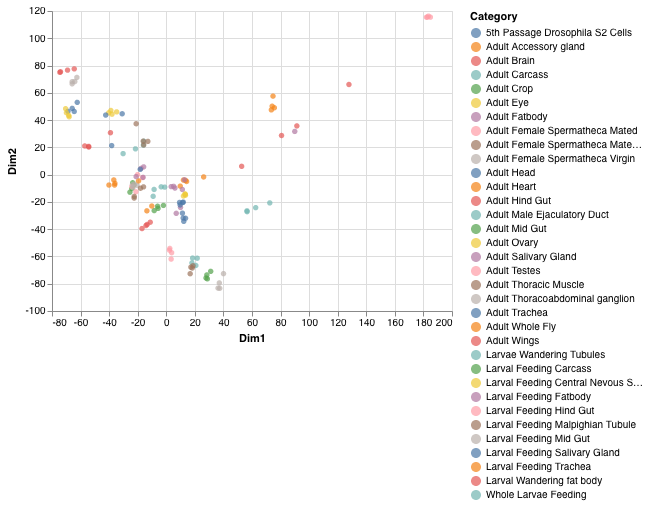

In [15]:
pca = PCA(n_components=2)
expression_pca = pca.fit_transform(log_expression.values.T)
plot_two_dimensions(expression_pca, sample_categories, expression.columns)

This code prints out the variance explained by component.

In [16]:
print(pca.explained_variance_ratio_)

[ 0.13853166  0.10866708]


This code makes a plot of the explained variance by component, like we saw on one of the lecture slides.

Text(0,0.5,'variance explained')

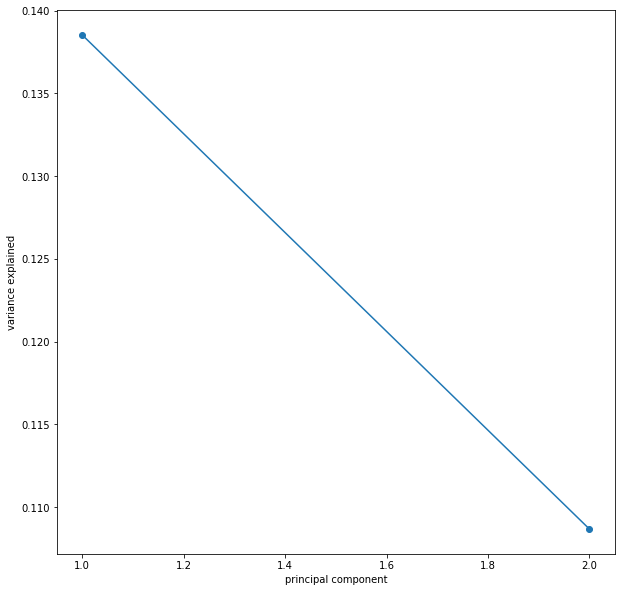

In [17]:
plt.plot([x + 1 for x in range(len(pca.explained_variance_ratio_))], pca.explained_variance_ratio_, 'o-')
plt.xlabel("principal component")
plt.ylabel("variance explained")

**Exercise:**

Re-run the PCA with a higher number of dimensions and see how the plot of variance explained changes. How many components do you think are worth keeping if you were going to do this analysis?

**Exercise:**

Try creating an MDS plot using `MDS()`, which we imported from `sklearn.manifold`. All scikit-learn models use a consistent syntax, so the syntax is extremely similar to that for `PCA()`.

Examine the documentation either online or just using `help(MDS)` in the notebook.

In [18]:
### YOUR CODE HERE

**Exercise:**

Try creating a tSNE plot using `TSNE()`, which we imported from `sklearn.manifold`. All scikit-learn models use a consistent syntax, so the syntax is extremely similar to that for `PCA()`.

Examine the documentation either online or just using `help(TSNE)` in the notebook.

`TSNE()` takes several parameters: the most important is `perplexity`. Lower values of perplexity try hard to preserve local structure at the cost of global structure, and vice versa. From the documentation, what is the default value of `perplexity`? What happens if you redo your plot with it set to a much lower or much higher value?

In [19]:
### YOUR CODE HERE

**Exercise:**

Try creating a UMAP plot using `UMAP()`, which we imported from the `umap` library. `umap` is not part of scikit-learn, but it deliberately uses a similar syntax.

Examine the documentation either online or just using `help(UMAP)` in the notebook.

Look at the available parameters in the documentation. Try varying `n_neighbours` (which has a conceptual similarity to tSNE's `perplexity`) and `min_dist`.

In [20]:
### YOUR CODE HERE